<a href="https://colab.research.google.com/github/Nareshedagotti/RAG/blob/main/Day_6_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **How RAG Uses Retrieved Info to Generate Smart Responses**

We dive into the Generation Layer, where retrieved context is combined with a Large Language Model (LLM) to produce accurate, context-aware responses. We’ll explore injecting context into prompts, prompt templates, RAG vs. traditional LLMs, and advanced techniques like RAG Fusion. Additionally, we’ll discuss how to choose the right LLM for your use case, integrate LLMs via APIs, run models locally with Ollama and LangChain, and highlight common mistakes and key considerations.

#### **Understanding Context Injection in RAG**

In RAG systems, the LLM generates responses by combining the user's query with relevant context retrieved from a vector database. This context injection process is what makes RAG responses more accurate and up-to-date than traditional LLM responses.
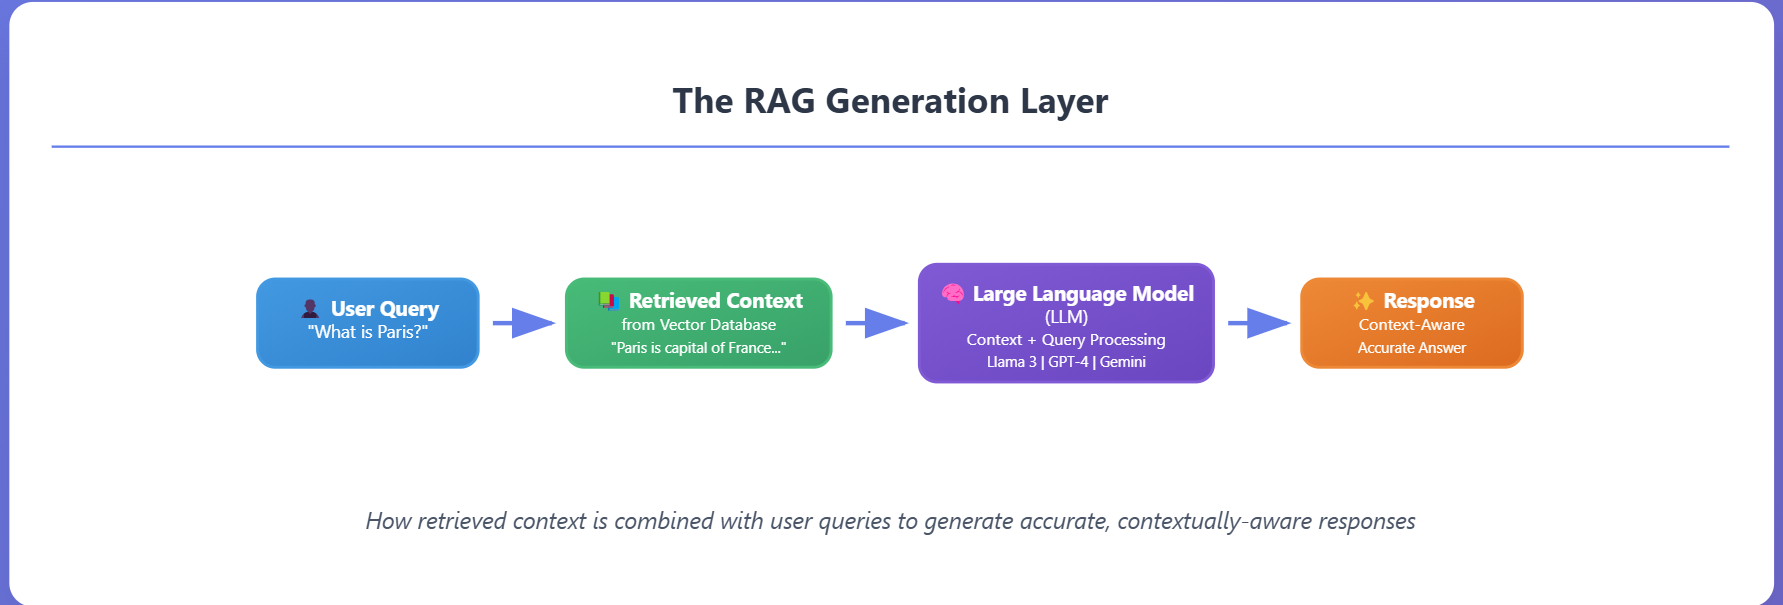


**The RAG Context Injection Process**

1. Retrieve top-k documents using vector similarity search
2. Format retrieved context and user query into a structured prompt
3. Send the combined prompt to the LLM for generation
4. Return the contextually-aware response

#### **Simple Context Injection Example**
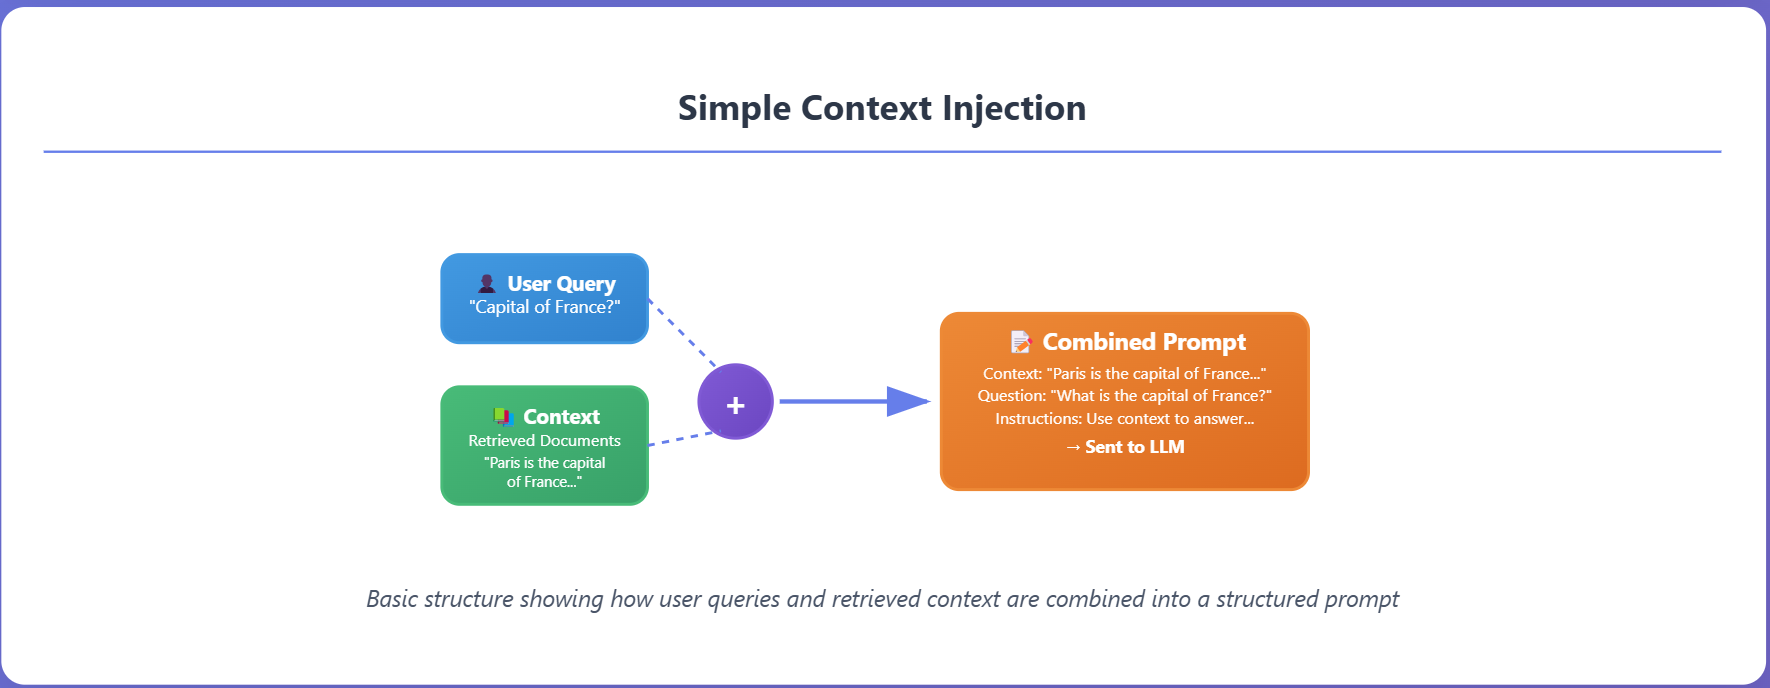

In [ ]:
# Basic context injection structure
def create_rag_prompt(query: str, contexts: list) -> str:
    context_text = "\n".join([f"Document {i+1}: {ctx}" for i, ctx in enumerate(contexts)])
    prompt = f"""
    Context: {context_text}

    Question: {query}
    Instructions: Use the provided context to answer the question accurately.
    If the context doesn't contain sufficient information, clearly state what's missing.
    Answer:
    """
    return prompt
# Example usage
query = "What is the capital of France?"
contexts = ["France is a country in Europe. Its capital is Paris, known for the Eiffel Tower."]
prompt = create_rag_prompt(query, contexts)

#### **Prompt Templates and System Messages**
Prompt templates structure the input to the LLM, ensuring consistency and clarity. They typically include placeholders for the context and query, along with instructions. System messages define the LLM’s behavior, such as tone or response style (e.g., "Be concise" or "Cite sources").
##### **Professional Prompt Template with LangChain**


In [ ]:
from langchain.prompts import PromptTemplate
# Basic RAG prompt template
basic_template = PromptTemplate(
    input_variables=["context", "question"],
    template="""
    Use the following context to answer the question accurately and comprehensively.
    Context: {context}
    Question: {question}
    Guidelines:
    - Base your answer primarily on the provided context
    - If the context is insufficient, clearly state what information is missing
    - Be specific and cite relevant parts of the context when possible
    - Maintain a professional and helpful tone
    Answer:
    """
)
# Advanced template with system instructions
advanced_template = PromptTemplate(
    input_variables=["context", "question", "chat_history"],
    template="""
    You are an expert assistant with access to relevant documentation.
    Use the provided context and conversation history to give accurate responses.

    Previous Conversation:
    {chat_history}
    Current Context:
    {context}
    Current Question: {question}
    Response Guidelines:
    - Prioritize information from the current context
    - Reference previous conversation when relevant
    - Be concise but thorough
    - Admit uncertainty when context is insufficient
    - Use bullet points for complex information
    Response:
    """
)

##### **System Message Strategies**


In [ ]:
SYSTEM_MESSAGES = {
    "professional": "Respond in a professional, business-appropriate tone with clear structure.",
    "conversational": "Be friendly and conversational while maintaining accuracy.",
    "technical": "Provide detailed technical responses with precise terminology.",
    "concise": "Give brief, direct answers focusing on key information only.",
    "educational": "Explain concepts clearly as if teaching someone new to the topic."
}

def create_system_prompt(style: str, context: str, question: str) -> str:
    system_msg = SYSTEM_MESSAGES.get(style, SYSTEM_MESSAGES["professional"])
    return f"{system_msg}\n\nContext: {context}\n\nQuestion: {question}\n\nAnswer:"


#### **RAG vs Traditional LLM: Side-by-Side Comparison**
Understanding the difference between RAG-enhanced and traditional LLM responses is crucial for appreciating RAG's value.
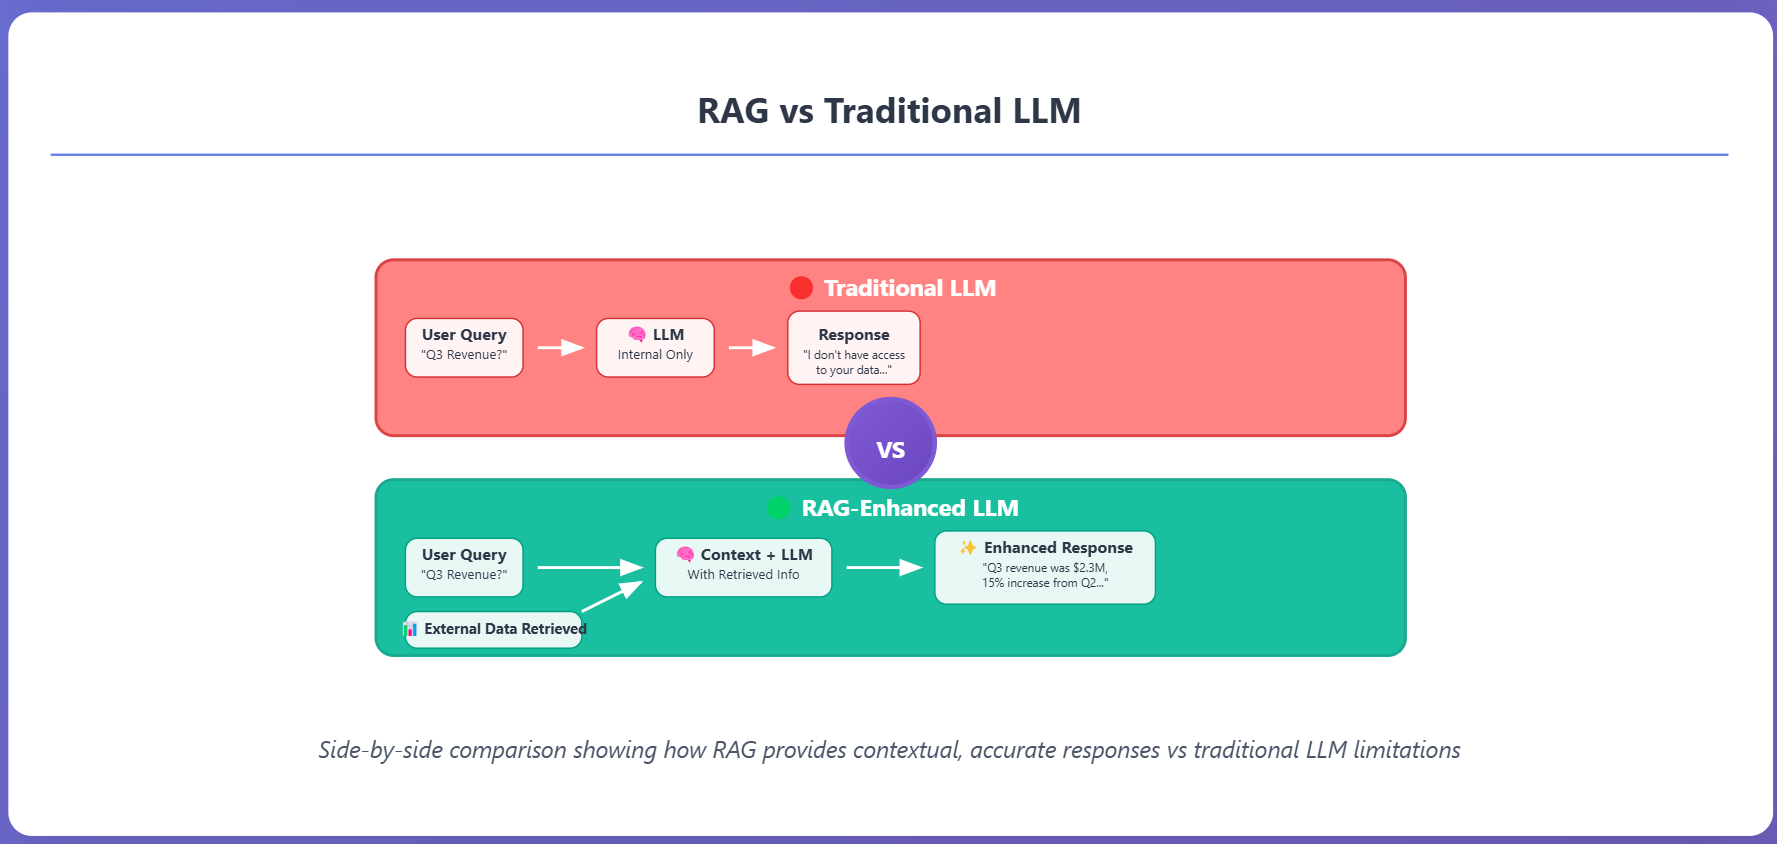


##### **Example 1: Current Events Query**
**Query:** "What are the latest advancements in quantum computing?"

**Traditional LLM Response:**

"Quantum computing has seen progress in quantum error correction and hardware development. Companies like IBM and Google are leading research efforts. Recent developments include improvements in qubit stability and quantum algorithms for optimization problems."

**RAG Response (with Retrieved Context):**

"Based on recent reports, IBM has unveiled their 127-qubit Condor processor, representing
a significant leap in quantum hardware scaling. Google's Willow chip has demonstrated
breakthrough error correction capabilities, reducing error rates exponentially as more
qubits are added. Additionally, new quantum algorithms for machine learning optimization
are showing 10x speedups over classical methods in financial modeling applications."

##### **Example 2: Company-Specific Query**

**Query:** "What was our Q3 2024 revenue performance?"

**Traditional LLM Response:**

"I don't have access to your company's specific financial data. You'll need to check
your internal financial reports or contact your finance team for Q3 2024 revenue figures."

**RAG Response (with Retrieved Context):**

"According to the Q3 2024 financial report, total revenue reached $2.3M, representing
a 15% increase from Q2 2024. Key growth drivers included Widget A sales (40% of revenue)
and successful expansion into the European market, contributing $400K in new revenue."

**Key Differences:**

* Specificity: RAG provides precise, current information
* Context Awareness: RAG understands domain-specific queries
* Freshness: RAG accesses up-to-date information beyond training data


#### **RAG Fusion / Multi-query RAG**

RAG Fusion (or Multi-query RAG) enhances retrieval by generating multiple related queries from the original question, retrieving documents for each, and combining them for a richer context.

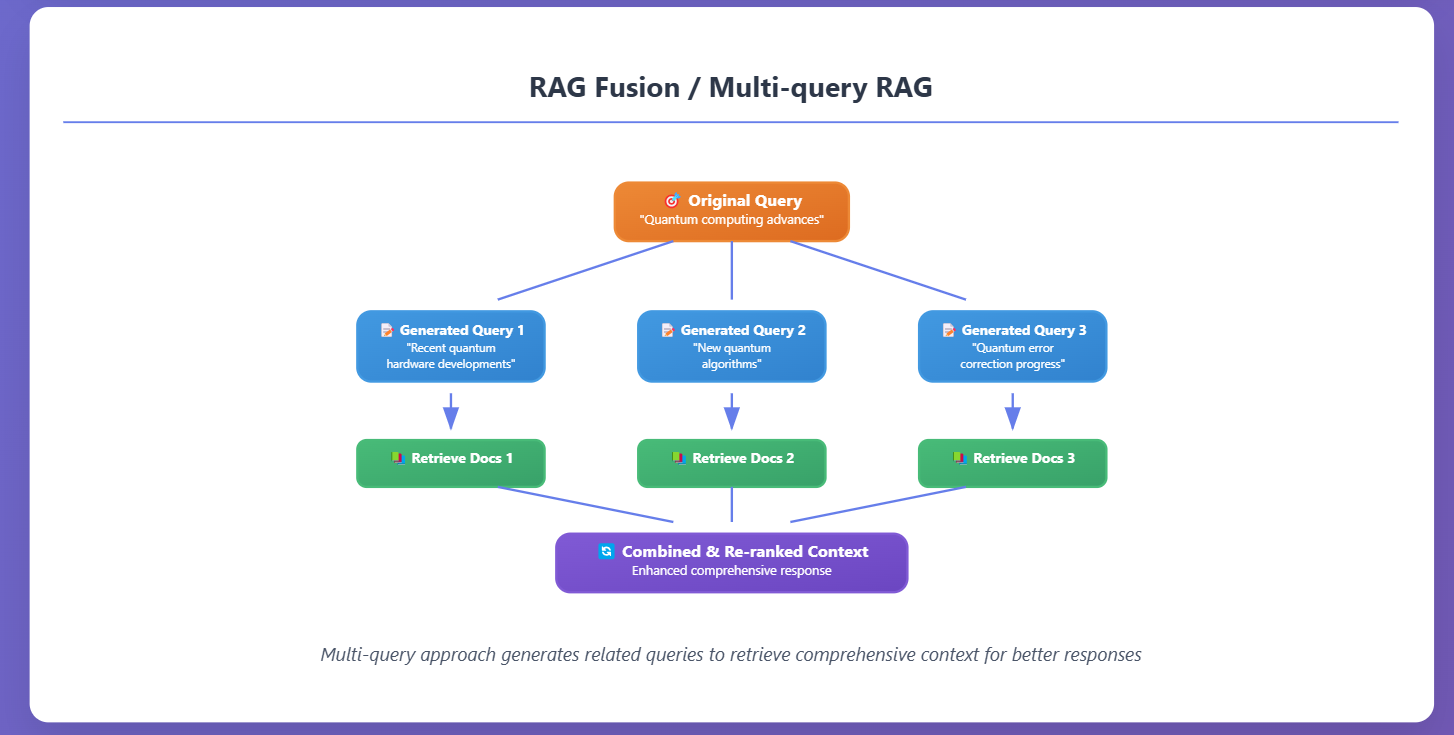

##### **Example Workflow**
**Original Query:** "What are quantum computing advancements?"

**Generated Queries:**

"Recent quantum hardware developments"

"New quantum algorithms"

"Quantum error correction progress"

**Process:**

Retrieve documents for each query, merge and re-rank them, then pass the combined context to the LLM.

This approach ensures comprehensive coverage, especially for complex or ambiguous queries.


#### **Choosing the Right LLM for Your Use Case**

Selecting an LLM for a RAG pipeline depends on factors like context window size, model size, memory requirements, and the specific use case. Below is a comparison to guide your choice:

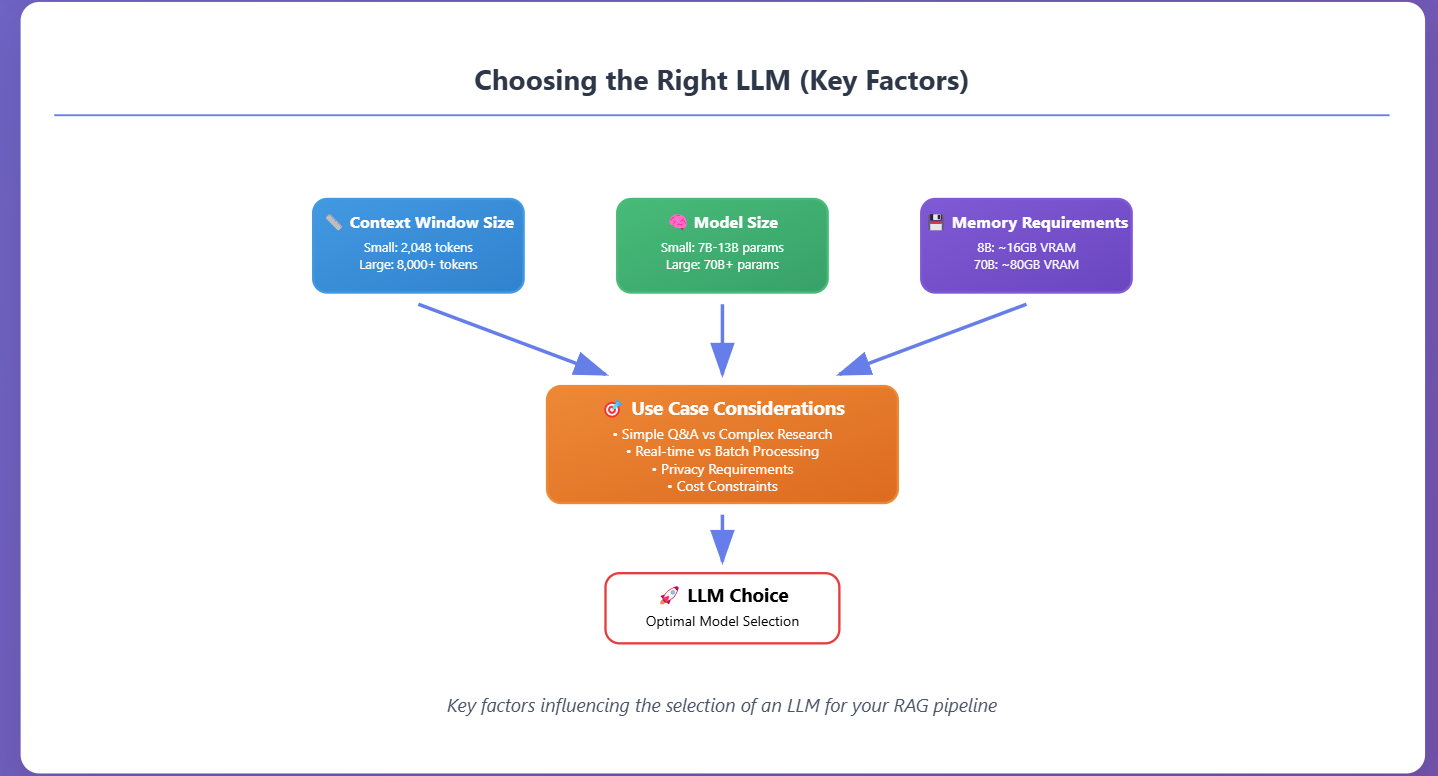

##### Key Factors to Consider

---

##### Context Window Size:

**Definition:** The maximum number of tokens (words, subwords, or characters) an LLM can process in a single prompt.

**Examples:**
- **Small Context (e.g., 2,048 tokens):** Models like BERT or smaller Llama variants (e.g., Llama 3 8B) are suitable for short queries and limited context, such as FAQ systems.
- **Large Context (e.g., 8,000–10,000+ tokens):** Models like Llama 3 70B or Gemini 1.5 are ideal for complex queries requiring extensive context, such as research summarization.

**Impact:** If the retrieved context + query exceeds the window, truncation occurs, potentially losing critical information.

**Action:** Check the model’s documentation (e.g., Llama 3 supports ~8,000 tokens). Use token counting tools (e.g., `tiktoken`) to ensure the input fits.

---

##### Model Size:

**Definition:** The number of parameters in the model, affecting performance and resource needs.

**Examples:**
- **Small Models (e.g., 7B–13B parameters):** Llama 3 8B or Mistral 7B are lightweight, suitable for local deployment on modest hardware (e.g., 16GB GPU).
- **Large Models (e.g., 70B+ parameters):** Llama 3 70B or Mixtral 8x22B offer higher accuracy but require significant resources (e.g., 80GB GPU or cloud infrastructure).

**Impact:** Larger models provide better reasoning but increase latency and cost.

**Action:** Choose smaller models for simple tasks (e.g., chatbots) and larger ones for complex tasks (e.g., technical document analysis).

---

##### Memory Requirements:

**Definition:** The GPU/CPU memory needed to run the model, especially for local deployment.

**Examples:**
- **Llama 3 8B:** ~16GB VRAM for inference with 4-bit quantization.
- **Llama 3 70B:** ~80GB VRAM without quantization, or ~40GB with 4-bit quantization.

**Impact:** Insufficient memory leads to crashes or slow performance.

**Action:** Use quantization (e.g., 4-bit or 8-bit) to reduce memory needs, or opt for cloud-based APIs for large models.

---

##### Use Case Considerations:

- **Simple Q&A (e.g., customer support):** Smaller models with 2,000–4,000 token windows (e.g., Mistral 7B) are sufficient.
- **Research or Summarization:** Larger models with 8,000+ token windows (e.g., Llama 3 70B) handle extensive context better.
- **Real-Time Applications:** Prioritize smaller models or APIs with low latency (e.g., Groq’s Llama 3.3 70B).
- **Privacy-Sensitive Tasks:** Use local models (e.g., via Ollama) to avoid sending sensitive data to APIs.

---

##### Other Factors:

- **Cost:** APIs like Google or Groq have per-token costs, while local models require upfront hardware investment.
- **Latency:** Cloud APIs may be faster for large models but depend on internet connectivity.
- **Domain Expertise:** Fine-tuned models (e.g., for legal or medical domains) may outperform general-purpose models.

---

##### Example Decision

**Use Case:** Building a RAG system for a customer support chatbot with short queries and limited context.  
**Choice:** Mistral 7B (4,096 tokens, ~12GB VRAM with quantization) via Ollama for cost-effective local deployment.

**Use Case:** Summarizing large research papers with complex queries.  
**Choice:** Llama 3 70B (8,000 tokens, cloud API via Groq) for handling extensive context and high accuracy.


#### **Integrating LLMs Using APIs**

APIs from providers like Google Generative AI, Groq, OpenAI, and Anthropic simplify LLM integration by handling infrastructure. Below, we provide practical implementations for two APIs:

##### **Google Generative AI and Groq.**

Google Generative AI Example
This code sets up the Google Generative AI API to generate content.


In [ ]:
import google.generativeai as genai

# Configure the API key
genai.configure(api_key='your_api_key')
# Choose a model
model = genai.GenerativeModel('gemini-2.0-flash')
# Generate content
response = model.generate_content("Write a short story about a cat and a dog who become friends.")
print(response.text)

* genai.configure(api_key='your_api_key'): Authenticates with your API key.
* model = genai.GenerativeModel('gemini-2.0-flash'): Selects the Gemini 2.0 Flash model (~4,000-token context window).
* Use Case: Suitable for general-purpose tasks with moderate context needs.


#### **Groq Example**
This code uses the Groq API for fast inference with Llama models.


In [ ]:
import os
from groq import Groq
# Initialize the client with your API key
client = Groq(api_key="your_api_key")
# Get user input
query = input("Enter your query: ")
# Create a chat completion
chat_completion = client.chat.completions.create(

    messages=[{"role": "user", "content": query}],    model="llama-3.3-70b-versatile",
)
# Print the response
print(chat_completion.choices[0].message.content)

* client = Groq(api_key="your_api_key"): Initializes the Groq client.
* model="llama-3.3-70b-versatile": Uses Llama 3.3 70B (~8,000-token context window) for high accuracy.
* Use Case: Ideal for complex queries requiring large context or low-latency responses.


##### Running LLMs Locally with Ollama and Integrating with LangChain

For enhanced privacy, reduced operational costs, and robust offline capabilities, leveraging Large Language Models (LLMs) locally via **Ollama** and integrating them into a Retrieval-Augmented Generation (RAG) pipeline with **LangChain** offers a powerful solution. This approach allows you to maintain full control over your data and models.

---

##### Prerequisites

Before running the example, ensure you have the following set up:

**Install Ollama and Pull a Model:**
- Download and install Ollama from its official website.
- Pull the desired LLM model (e.g., Llama 3) using:
  ```bash
  ollama pull llama3


##### 2. Install LangChain and Dependencies

Install the necessary Python packages:

```bash
pip install langchain langchain-community faiss-cpu sentence-transformers langchain-ollama



##### Have a FAISS Index with Embeddings

This example assumes you have a pre-existing **FAISS** vector index (e.g., named `faiss_index`) that contains embeddings of your documents.

If you don't have one, the provided code includes **commented-out instructions** on how to create a basic index.

The embeddings used to create this index should ideally be **compatible with the `OllamaEmbeddings`** model you plan to use for retrieval.


#### **Local RAG Pipeline Example**
This Python code demonstrates how to set up a RAG system using Ollama for both embeddings and the LLM, combined with FAISS for efficient document retrieval.


In [ ]:
from langchain_ollama.llms import OllamaLLM
from langchain_community.embeddings import OllamaEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate


# Set up prompt template
prompt_template = PromptTemplate(
    input_variables=["context", "question"],
    template="Use the following context to answer the question. If the context doesn't provide enough information, say so.\n\nContext: {context}\n\nQuestion: {question}\n\nAnswer:"
)


# Set up local embeddings using OllamaEmbeddings
embeddings = OllamaEmbeddings(model="llama3")


# Load FAISS index
try:
    vectorstore = FAISS.load_local("faiss_index", embeddings, allow_dangerous_deserialization=True)
except Exception as e:
    print(f"Error loading FAISS index: {e}")
    print("Please ensure 'faiss_index' exists and was created correctly with compatible embeddings.")
    print("If you don't have one, you'll need to create it first, for example:")
    print("from langchain.text_splitter import RecursiveCharacterTextSplitter")
    print("from langchain_community.document_loaders import TextLoader")
    print("loader = TextLoader('your_document.txt')")
    print("documents = loader.load()")
    print("text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)")
    print("docs = text_splitter.split_documents(documents)")
    print("vectorstore = FAISS.from_documents(docs, embeddings)")
    print("vectorstore.save_local('faiss_index')")
    exit()


# Configure the retriever to fetch relevant documents.
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})


# Set up local LLM with OllamaLLM
llm = OllamaLLM(model="llama3")


# Create the RAG chain
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever,
    chain_type_kwargs={"prompt": prompt_template}
)


# Run a query
print("Running query...")
response = qa_chain.invoke({"query": "What is the capital of France?"})
print("\n--- Response ---")
print(response['result'])

##### Explanation of Components

- **`OllamaEmbeddings(model="llama3")`**:  
  This component generates numerical representations (embeddings) of text. It uses a model served by **Ollama** — in this case, `llama3`.  
  > 🔹 For production, a dedicated embedding model like `nomic-embed-text` is often recommended.  
  These embeddings are critical for comparing the similarity between your query and documents in the vector store.

- **`FAISS.load_local("faiss_index", embeddings, ...)`**:  
  Loads your pre-built **FAISS** vector index from a local directory named `"faiss_index"`.  
  FAISS (Facebook AI Similarity Search) is a library for efficient similarity search and clustering of dense vectors.  
  The `embeddings` object is passed to ensure compatibility during loading and retrieval.

- **`OllamaLLM(model="llama3")`**:  
  Initializes the LLM that will generate the final answer. It connects to the `llama3` model running locally via your Ollama server.  
  > 🔹 Llama 3 typically offers a context window of around **8,000 tokens**, suitable for most RAG applications.

- **`RetrievalQA`**:  
  This is a **LangChain** chain that orchestrates the entire RAG process.  
  It takes a user query, uses the retriever to find relevant documents from the vectorstore, and then passes those documents along with the question to the LLM — formatted via a prompt template — to generate a coherent response.

---

##### Use Case

This setup is ideal for applications requiring:

- **Privacy**: Your data and model interactions stay entirely on your local machine.  
- **Cost-Effectiveness**: No API usage fees for cloud-hosted LLMs.  
- **Offline Capability**: Full functionality even without internet access, provided Ollama and your models are installed locally.

---

##### Common Mistakes

- **Exceeding Context Window**  
  - *Issue*: Retrieved context + query exceeds the model’s token limit → truncation.  
  - *Solution*: Limit retrieved documents (e.g., `k=3`), summarize the context, or use models with larger context windows.

- **Poor Prompt Design**  
  - *Issue*: Vague or unstructured prompts lead to irrelevant or verbose responses.  
  - *Solution*: Use clear and structured prompt templates with specific instructions.

- **Ignoring Tokenization Differences**  
  - *Issue*: Different models tokenize differently → miscalculated context length.  
  - *Solution*: Use libraries like `tiktoken` or model-specific tools to test tokenization.

- **Not Handling API Rate Limits**  
  - *Issue*: API calls fail due to rate limits or token overuse.  
  - *Solution*: Implement retry logic and cache frequent queries.

---

##### Key Considerations When Sending Data and Configuring LLMs

- **Context Window Size Variations**  
  - *Example*: Llama 3 8B supports ~8,000 tokens, Gemini 1.5 supports 10,000+; smaller models like BERT support only ~2,048.  
  - *Action*: Check the model’s token limit. Ensure total input (query + context) fits using `tiktoken` or LangChain's token counter.

- **Tokenization Differences**  
  - *Action*: Understand how your model tokenizes input (e.g., byte-pair for GPT vs wordpiece for BERT).  
  - *Test* tokenization to prevent truncation surprises.

- **Balancing Context and Query**  
  - *Issue*: Long contexts can overshadow user queries.  
  - *Action*: Limit the number of retrieved docs or summarize before passing to the LLM.

- **Model-Specific Prompt Requirements**  
  - *Example*: Some models require special formatting like `<|user|>query<|end|>`.  
  - *Action*: Refer to model documentation and test prompts for expected behavior.

- **Sensitive Data Handling**  
  - *Issue*: Cloud APIs may expose sensitive data.  
  - *Action*: Prefer **local models** (like those served via **Ollama**) or anonymize input before sending to cloud APIs.

- **API Rate Limits and Costs**  
  - *Issue*: APIs charge per token and may throttle requests.  
  - *Action*: Monitor usage, cache responses, and implement retry mechanisms.

- **Local Hardware Constraints**  
  - *Issue*: Large models (e.g., Llama 3 70B) demand high VRAM.  
  - *Action*: Use quantization (e.g., 4-bit), or select smaller models for limited hardware setups.
